In [1]:
%reset -f
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config Completer.use_jedi = False

In [2]:
import libmr
from openmax import compute_train_score_and_mavs_and_dists,fit_weibull,openmax,compute_channel_distances
from evaluation import Evaluation
from sklearn.metrics import balanced_accuracy_score
from tqdm import tqdm
# from tqdm.notebook import tqdm as tqdm
import numpy as np
import pandas as pd
import torch
torch.manual_seed(42)
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torch.utils.data import Dataset, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
import copy
from losses import *
import time
torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE = False
torchaudio.set_audio_backend('soundfile')
import os
import random
from pathlib import Path

import matplotlib.pyplot as plt
import psutil
import requests

from utils import *
from wingbeat_datasets import *
from wingbeat_models import *

losschoice = 'ce'
num_classes = 2
num_epochs = 30
batch_size = 32
batch_size_val = batch_size * 2
validation_split = .2
shuffle_dataset = True
num_workers = psutil.cpu_count()
random_seed= 42
setting = 'raw'
modeltype = 'conv1draw'
normalize = ""#"sample"

/home/kalfasyan/anaconda3/envs/wbai/lib/python3.6/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


Available workers: 16


In [3]:
transforms_list = [FilterWingbeat(setting='bandpass')]

if normalize == "whole":
    dmel1 = WingbeatsDataset(dsname="Melanogaster_RL/Y", clean=True,transform=transforms.Compose(transforms_list))
    dsuz1 = WingbeatsDataset(dsname="Suzukii_RL/L", clean=True, transform=transforms.Compose(transforms_list))
    transformed_dataset = ConcatDataset([dmel1, dsuz1])
    trainval_dataloader = DataLoader(transformed_dataset, batch_size=batch_size, num_workers=num_workers)

    mean, std = calc_mean_std_1D(loader=trainval_dataloader)
    transforms_list += [Normalize(mean=mean, std=std, axes=(0,2))]
elif normalize == "sample":
    transforms_list += [Normalize()]
else:
    pass

dmel1 = WingbeatsDataset(dsname="Melanogaster_RL/Z", custom_label=[0], clean=True, transform=transforms.Compose(transforms_list))
dmel2 = WingbeatsDataset(dsname="Melanogaster_RL/Y", custom_label=[0], clean=True, transform=transforms.Compose(transforms_list))
dsuz1 = WingbeatsDataset(dsname="Suzukii_RL/Y",      custom_label=[1], clean=True, transform=transforms.Compose(transforms_list))
dsuz2 = WingbeatsDataset(dsname="Suzukii_RL/X",      custom_label=[1], clean=True, transform=transforms.Compose(transforms_list))

transformed_dataset = ConcatDataset([dmel1, dsuz1])
trainval_dataloader = DataLoader(transformed_dataset, batch_size=batch_size, num_workers=num_workers)
train_size = int(0.8 * len(transformed_dataset))
valid_size = len(transformed_dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(transformed_dataset, [train_size, valid_size])
test_dataset = ConcatDataset([dmel2, dsuz2])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size_val, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_val, num_workers=num_workers)

Found 12150 in dataset: Melanogaster_RL/Z, and 1 label(s): ['D. melanogaster']
Label(s) changed to [0]
Found 12003 in dataset: Melanogaster_RL/Y, and 1 label(s): ['D. melanogaster']
Label(s) changed to [0]
Found 18166 in dataset: Suzukii_RL/Y, and 1 label(s): ['D. suzukii']
Label(s) changed to [1]
Found 14703 in dataset: Suzukii_RL/X, and 1 label(s): ['D. suzukii']
Label(s) changed to [1]


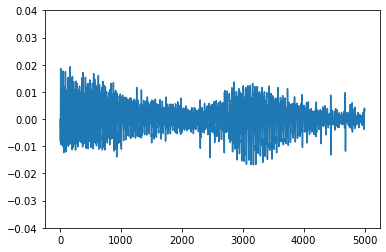

In [4]:
from IPython.display import Audio
sig = train_dataset[6][0]
plt.plot(sig.T); plt.ylim(-.04,.04)
Audio(sig, rate=8000, autoplay=True)

In [5]:
if setting.startswith('psd'):
    model = Conv1dNetPSD()
elif modeltype == 'conv1draw':
    model = Conv1dNetRAW()
elif modeltype == 'inception':
    model = nn.Sequential(
                    InceptionBlock(
                        in_channels=1, 
                        n_filters=32, 
                        kernel_sizes=[5, 11, 23],
                        bottleneck_channels=32,
                        use_residual=True,
                        activation=nn.ReLU()
                    ),
                    InceptionBlock(
                        in_channels=32*4, 
                        n_filters=32, 
                        kernel_sizes=[5, 11, 23],
                        bottleneck_channels=32,
                        use_residual=True,
                        activation=nn.ReLU()
                    ),
                    nn.AdaptiveAvgPool1d(output_size=1),
                    Flatten(out_features=32*4*1),
                    nn.Linear(in_features=4*32*1, out_features=2))


In [6]:
if losschoice == 'digamma':
    criterion = edl_digamma_loss
elif losschoice == 'log':
    criterion = edl_log_loss
elif losschoice == 'mse':
    criterion = edl_mse_loss
else:
    criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999))
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)
early_stopping = EarlyStopping(patience=7, verbose=1)

In [7]:
train_class_num = 2
weibull_tail = 20
weibull_alpha = 2
weibull_threshold = 0.9

In [8]:
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

## Training

In [9]:
# Choosing whether to train on a gpu
train_on_gpu = torch.cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')# Number of gpus
device = 'cuda'
model = model.to(device, dtype=torch.float)

# Model training
for epoch in range(num_epochs):
    # Going through the training set
    correct_train = 0
    model.train()
    for x_batch,y_batch,path_batch,idx_batch in tqdm(train_dataloader, desc=f'Epoch: {epoch}\tTraining..'):        

        y_batch = torch.as_tensor(y_batch).type(torch.LongTensor)
        x_batch,y_batch = x_batch.cuda(), y_batch.cuda()
        
        optimizer.zero_grad()
        pred = model(x_batch)
        loss = criterion(pred, y_batch)
        loss.backward()
        optimizer.step()
        correct_train += (pred.argmax(axis=1) == y_batch).float().sum().item()

    train_accuracy = correct_train / (len(train_dataloader)*batch_size) * 100.
    # Going through the validation set
    if epoch != 0:
        correct_valid = 0
        model.eval()
        scores, labels = [],[]
        with torch.no_grad():
            for x_batch,y_batch,path_batch,idx_batch in tqdm(valid_dataloader, desc='Validating..\t'):

                y_batch = torch.as_tensor(y_batch).type(torch.LongTensor)
                x_batch,y_batch = x_batch.cuda(), y_batch.cuda()

                pred = model(x_batch)
                
                scores.append(pred)
                labels.append(y_batch)
                
                val_loss = criterion(pred, y_batch)
                correct_valid += (pred.argmax(axis=1) == y_batch).float().sum().item()
            valid_accuracy = correct_valid / (len(valid_dataloader)*batch_size_val) * 100.
            scheduler.step(val_loss)
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                print("Early stopping")
                break

            scores = torch.cat(scores,dim=0).cpu().numpy()
            labels = torch.cat(labels,dim=0).cpu().numpy()
            scores = np.array(scores)[:, np.newaxis, :]
            labels = np.array(labels)


            # Fit the weibull distribution from training data.
            print("Fittting Weibull distribution...")
            _, mavs, dists = compute_train_score_and_mavs_and_dists(train_class_num, valid_dataloader, device, model)
            categories = list(range(0, train_class_num))
            weibull_model = fit_weibull(mavs, dists, categories, weibull_tail, "euclidean")

        pred_softmax, pred_softmax_threshold, pred_openmax = [], [], []
        score_softmax, score_openmax = [], []
        for score in scores:
            so, ss = openmax(weibull_model, categories, score,
                             0.5, weibull_alpha, "euclidean")  # openmax_prob, softmax_prob
            pred_softmax.append(np.argmax(ss))
            pred_softmax_threshold.append(np.argmax(ss) if np.max(ss) >= weibull_threshold else train_class_num)
            pred_openmax.append(np.argmax(so) if np.max(so) >= weibull_threshold else train_class_num)
            score_softmax.append(ss)
            score_openmax.append(so)

        print("Evaluation...")
        print(f"Softmax: {balanced_accuracy_score(y_true=labels, y_pred=pred_softmax)}")
        print(f"Thr_Softmax: {balanced_accuracy_score(y_true=labels, y_pred=pred_softmax_threshold)}")
        print(f"Openmax: {balanced_accuracy_score(y_true=labels, y_pred=pred_openmax)}")
        
        # Printing results
        print(f"Epoch {epoch}: train_acc: {train_accuracy:.2f}% loss: {loss:.3f},  val_loss: {val_loss:.3f} val_acc: {valid_accuracy:.2f}%")


Train on gpu: True


Validating..	: 100%|██████████| 95/95 [00:01<00:00, 83.38it/s] 

Validation loss decreased (inf --> 1.438599).  Saving model ...
Fittting Weibull distribution...



/home/kalfasyan/anaconda3/envs/wbai/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
Epoch: 2	Training..:   0%|          | 0/758 [00:00<?, ?it/s]

Evaluation...
Softmax: 0.6079378264341063
Thr_Softmax: 0.4944673392134559
Openmax: 0.3818554764645353
Epoch 1: train_acc: 93.06% loss: 0.067,  val_loss: 1.439 val_acc: 65.90%


Validating..	: 100%|██████████| 95/95 [00:01<00:00, 64.37it/s] 

Fittting Weibull distribution...



Epoch: 3	Training..:   0%|          | 0/758 [00:00<?, ?it/s]

Evaluation...
Softmax: 0.5158883669521968
Thr_Softmax: 0.5125725338491296
Openmax: 0.5080960461459091
Epoch 2: train_acc: 93.97% loss: 0.056,  val_loss: 11.815 val_acc: 42.11%


Validating..	: 100%|██████████| 95/95 [00:01<00:00, 79.91it/s] 

Fittting Weibull distribution...



Epoch: 4	Training..:   0%|          | 0/758 [00:00<?, ?it/s]

Evaluation...
Softmax: 0.5887423849700315
Thr_Softmax: 0.4744561621209578
Openmax: 0.20186128538824008
Epoch 3: train_acc: 94.69% loss: 0.028,  val_loss: 1.721 val_acc: 50.90%


Validating..	: 100%|██████████| 95/95 [00:01<00:00, 78.87it/s] 

Fittting Weibull distribution...



Epoch: 5	Training..:   0%|          | 0/758 [00:00<?, ?it/s]

Evaluation...
Softmax: 0.5028629856850716
Thr_Softmax: 0.5008843351748977
Openmax: 0.4990328820116054
Epoch 4: train_acc: 95.14% loss: 0.042,  val_loss: 8.415 val_acc: 59.75%


Validating..	: 100%|██████████| 95/95 [00:01<00:00, 79.90it/s] 

Epoch     5: reducing learning rate of group 0 to 1.0000e-03.
Fittting Weibull distribution...



Epoch: 6	Training..:   0%|          | 0/758 [00:00<?, ?it/s]

Evaluation...
Softmax: 0.5009671179883946
Thr_Softmax: 0.5008289582757668
Openmax: 0.49959648322786293
Epoch 5: train_acc: 95.78% loss: 0.019,  val_loss: 34.522 val_acc: 40.33%


Validating..	: 100%|██████████| 95/95 [00:01<00:00, 79.90it/s] 


Validation loss decreased (1.438599 --> 0.041037).  Saving model ...
Fittting Weibull distribution...


Epoch: 7	Training..:   0%|          | 0/758 [00:00<?, ?it/s]

Evaluation...
Softmax: 0.9693202372617593
Thr_Softmax: 0.9014173095755135
Openmax: 0.7759927015507226
Epoch 6: train_acc: 97.47% loss: 0.010,  val_loss: 0.041 val_acc: 97.06%


Validating..	: 100%|██████████| 95/95 [00:01<00:00, 80.99it/s] 

Validation loss decreased (0.041037 --> 0.016826).  Saving model ...
Fittting Weibull distribution...



Epoch: 8	Training..:   0%|          | 0/758 [00:00<?, ?it/s]

Evaluation...
Softmax: 0.9743066444933042
Thr_Softmax: 0.9209796512498509
Openmax: 0.7986242230988347
Epoch 7: train_acc: 97.98% loss: 0.017,  val_loss: 0.017 val_acc: 97.09%


Validating..	: 100%|██████████| 95/95 [00:01<00:00, 80.57it/s] 

Fittting Weibull distribution...



Epoch: 9	Training..:   0%|          | 0/758 [00:00<?, ?it/s]

Evaluation...
Softmax: 0.8155068879256322
Thr_Softmax: 0.760961207352018
Openmax: 0.6999823132965021
Epoch 8: train_acc: 98.18% loss: 0.005,  val_loss: 1.050 val_acc: 77.83%


Validating..	: 100%|██████████| 95/95 [00:01<00:00, 80.25it/s] 

Fittting Weibull distribution...



Epoch: 10	Training..:   0%|          | 0/758 [00:00<?, ?it/s]

Evaluation...
Softmax: 0.9585290313393694
Thr_Softmax: 0.8904474848999062
Openmax: 0.7628546452459779
Epoch 9: train_acc: 98.52% loss: 0.015,  val_loss: 0.053 val_acc: 95.13%


Validating..	: 100%|██████████| 95/95 [00:01<00:00, 79.64it/s] 

Fittting Weibull distribution...



Epoch: 11	Training..:   0%|          | 0/758 [00:00<?, ?it/s]

Evaluation...
Softmax: 0.8801212189020569
Thr_Softmax: 0.8269626166375939
Openmax: 0.7550965111988477
Epoch 10: train_acc: 98.71% loss: 0.015,  val_loss: 0.444 val_acc: 85.59%


Validating..	: 100%|██████████| 95/95 [00:01<00:00, 79.92it/s] 

Epoch    11: reducing learning rate of group 0 to 1.0000e-04.
Fittting Weibull distribution...



Epoch: 12	Training..:   0%|          | 0/758 [00:00<?, ?it/s]

Evaluation...
Softmax: 0.8927542717909511
Thr_Softmax: 0.8403087883703991
Openmax: 0.7798439953641625
Epoch 11: train_acc: 98.94% loss: 0.007,  val_loss: 0.191 val_acc: 91.05%


Validating..	: 100%|██████████| 95/95 [00:01<00:00, 69.37it/s] 

Validation loss decreased (0.016826 --> 0.010191).  Saving model ...
Fittting Weibull distribution...



Epoch: 13	Training..:   0%|          | 0/758 [00:00<?, ?it/s]

Evaluation...
Softmax: 0.974621332198672
Thr_Softmax: 0.9430748079749516
Openmax: 0.8750019636196376
Epoch 12: train_acc: 99.23% loss: 0.005,  val_loss: 0.010 val_acc: 97.24%


Validating..	: 100%|██████████| 95/95 [00:01<00:00, 79.60it/s] 


Validation loss decreased (0.010191 --> 0.008111).  Saving model ...
Fittting Weibull distribution...


Epoch: 14	Training..:   0%|          | 0/758 [00:00<?, ?it/s]

Evaluation...
Softmax: 0.9744886536689173
Thr_Softmax: 0.9416542774981621
Openmax: 0.8737305552212222
Epoch 13: train_acc: 99.29% loss: 0.013,  val_loss: 0.008 val_acc: 97.24%


Validating..	: 100%|██████████| 95/95 [00:01<00:00, 77.72it/s] 

Validation loss decreased (0.008111 --> 0.006999).  Saving model ...
Fittting Weibull distribution...



Epoch: 15	Training..:   0%|          | 0/758 [00:00<?, ?it/s]

Evaluation...
Softmax: 0.9732890657182525
Thr_Softmax: 0.9394596005743376
Openmax: 0.8735693406363032
Epoch 14: train_acc: 99.33% loss: 0.007,  val_loss: 0.007 val_acc: 97.22%


Validating..	: 100%|██████████| 95/95 [00:01<00:00, 80.36it/s] 

Fittting Weibull distribution...



Epoch: 16	Training..:   0%|          | 0/758 [00:00<?, ?it/s]

Evaluation...
Softmax: 0.9721393734838455
Thr_Softmax: 0.93981870281309
Openmax: 0.8740830461363029
Epoch 15: train_acc: 99.38% loss: 0.011,  val_loss: 0.007 val_acc: 97.15%


Validating..	: 100%|██████████| 95/95 [00:01<00:00, 79.25it/s] 

Fittting Weibull distribution...



Epoch: 17	Training..:   0%|          | 0/758 [00:00<?, ?it/s]

Evaluation...
Softmax: 0.968419458538242
Thr_Softmax: 0.9307319187360957
Openmax: 0.8667424426072122
Epoch 16: train_acc: 99.42% loss: 0.006,  val_loss: 0.009 val_acc: 96.94%


Validating..	: 100%|██████████| 95/95 [00:01<00:00, 76.07it/s] 

Validation loss decreased (0.006999 --> 0.006182).  Saving model ...
Fittting Weibull distribution...



Epoch: 18	Training..:   0%|          | 0/758 [00:00<?, ?it/s]

Evaluation...
Softmax: 0.9739579395498988
Thr_Softmax: 0.9425051605054215
Openmax: 0.8806440220354853
Epoch 17: train_acc: 99.37% loss: 0.006,  val_loss: 0.006 val_acc: 97.24%


Validating..	: 100%|██████████| 95/95 [00:01<00:00, 80.88it/s] 

Fittting Weibull distribution...



Epoch: 19	Training..:   0%|          | 0/758 [00:00<?, ?it/s]

Evaluation...
Softmax: 0.9746986338292957
Thr_Softmax: 0.9435885134749513
Openmax: 0.882932444138553
Epoch 18: train_acc: 99.48% loss: 0.002,  val_loss: 0.006 val_acc: 97.27%


Validating..	: 100%|██████████| 95/95 [00:01<00:00, 79.16it/s] 

Fittting Weibull distribution...



Epoch: 20	Training..:   0%|          | 0/758 [00:00<?, ?it/s]

Evaluation...
Softmax: 0.9742951170571585
Thr_Softmax: 0.9423724819756669
Openmax: 0.8844741257089515
Epoch 19: train_acc: 99.46% loss: 0.010,  val_loss: 0.007 val_acc: 97.25%


Validating..	: 100%|██████████| 95/95 [00:01<00:00, 80.35it/s] 

Fittting Weibull distribution...



Epoch: 21	Training..:   0%|          | 0/758 [00:00<?, ?it/s]

Evaluation...
Softmax: 0.973842269639163
Thr_Softmax: 0.9480381603342052
Openmax: 0.8906102251749034
Epoch 20: train_acc: 99.47% loss: 0.017,  val_loss: 0.010 val_acc: 97.09%


Validating..	: 100%|██████████| 95/95 [00:01<00:00, 80.66it/s] 

Validation loss decreased (0.006182 --> 0.005135).  Saving model ...
Fittting Weibull distribution...



Epoch: 22	Training..:   0%|          | 0/758 [00:00<?, ?it/s]

Evaluation...
Softmax: 0.9724047305433547
Thr_Softmax: 0.9425490099684068
Openmax: 0.8824949101283783
Epoch 21: train_acc: 99.50% loss: 0.003,  val_loss: 0.005 val_acc: 97.15%


Validating..	: 100%|██████████| 95/95 [00:01<00:00, 70.89it/s] 

Fittting Weibull distribution...



Epoch: 23	Training..:   0%|          | 0/758 [00:00<?, ?it/s]

Evaluation...
Softmax: 0.9738861191021484
Thr_Softmax: 0.9437376355533253
Openmax: 0.887685251267029
Epoch 22: train_acc: 99.53% loss: 0.029,  val_loss: 0.006 val_acc: 97.22%


Validating..	: 100%|██████████| 95/95 [00:01<00:00, 80.18it/s] 

Validation loss decreased (0.005135 --> 0.004825).  Saving model ...
Fittting Weibull distribution...



Epoch: 24	Training..:   0%|          | 0/758 [00:00<?, ?it/s]

Evaluation...
Softmax: 0.9735434604120154
Thr_Softmax: 0.9449646294183561
Openmax: 0.889464883982571
Epoch 23: train_acc: 99.57% loss: 0.005,  val_loss: 0.005 val_acc: 97.19%


Validating..	: 100%|██████████| 95/95 [00:01<00:00, 80.04it/s] 

Fittting Weibull distribution...



Epoch: 25	Training..:   0%|          | 0/758 [00:00<?, ?it/s]

Evaluation...
Softmax: 0.9722884955622195
Thr_Softmax: 0.9425764158827727
Openmax: 0.8837712346392675
Epoch 24: train_acc: 99.52% loss: 0.002,  val_loss: 0.005 val_acc: 97.20%


Validating..	: 100%|██████████| 95/95 [00:01<00:00, 80.11it/s] 

Fittting Weibull distribution...



Epoch: 26	Training..:   0%|          | 0/758 [00:00<?, ?it/s]

Evaluation...
Softmax: 0.9741240702472918
Thr_Softmax: 0.9489499014234688
Openmax: 0.9011273719536348
Epoch 25: train_acc: 99.61% loss: 0.007,  val_loss: 0.008 val_acc: 97.14%


Validating..	: 100%|██████████| 95/95 [00:01<00:00, 80.33it/s] 

Fittting Weibull distribution...



Epoch: 27	Training..:   0%|          | 0/758 [00:00<?, ?it/s]

Evaluation...
Softmax: 0.9729250473670262
Thr_Softmax: 0.9479888296883467
Openmax: 0.8984864589354865
Epoch 26: train_acc: 99.60% loss: 0.006,  val_loss: 0.013 val_acc: 96.92%


Validating..	: 100%|██████████| 95/95 [00:01<00:00, 74.50it/s] 

Epoch    27: reducing learning rate of group 0 to 1.0000e-05.
Fittting Weibull distribution...



Epoch: 28	Training..:   0%|          | 0/758 [00:00<?, ?it/s]

Evaluation...
Softmax: 0.9737479593895205
Thr_Softmax: 0.9460534635707589
Openmax: 0.8961025964419778
Epoch 27: train_acc: 99.62% loss: 0.013,  val_loss: 0.005 val_acc: 97.20%


Validating..	: 100%|██████████| 95/95 [00:01<00:00, 79.18it/s] 

Fittting Weibull distribution...



Epoch: 29	Training..:   0%|          | 0/758 [00:00<?, ?it/s]

Evaluation...
Softmax: 0.9740133164490298
Thr_Softmax: 0.9463906410780187
Openmax: 0.8954616935950965
Epoch 28: train_acc: 99.66% loss: 0.003,  val_loss: 0.005 val_acc: 97.20%


Validating..	: 100%|██████████| 95/95 [00:01<00:00, 78.72it/s] 

Fittting Weibull distribution...


Evaluation...
Softmax: 0.9742068530607886
Thr_Softmax: 0.9476121537601763
Openmax: 0.8970812418665179
Epoch 29: train_acc: 99.64% loss: 0.004,  val_loss: 0.005 val_acc: 97.19%


## Testing

### testing on datasets with same conditions

In [10]:
# Choosing whether to train on a gpu
train_on_gpu = torch.cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')# Number of gpus
model = model.to('cuda', dtype=torch.float)

Train on gpu: True


In [11]:
test_dataset = ConcatDataset([dmel2, dsuz2])
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_val, num_workers=num_workers)

def test(model, loader):
    correct_test = 0
    model.eval()
    for x_batch,y_batch,path_batch,idx_batch in tqdm(loader, desc='Testing..\t'):

        y_batch = torch.as_tensor(y_batch).type(torch.LongTensor)
        x_batch,y_batch = x_batch.cuda(), y_batch.cuda()

        pred = model(x_batch)
        val_loss = criterion(pred, y_batch)
        correct_test += (pred.argmax(axis=1) == y_batch).float().sum().item()
    test_accuracy = correct_test / (len(test_dataloader)*batch_size_val) * 100.
    print(test_accuracy)

In [3]:
# test(model,test_dataloader)

In [12]:
correct_test = 0
model.eval()
scores, labels = [],[]
with torch.no_grad():
    for x_batch,y_batch,path_batch,idx_batch in tqdm(test_dataloader, desc='testating..\t'):

        y_batch = torch.as_tensor(y_batch).type(torch.LongTensor)
        x_batch,y_batch = x_batch.cuda(), y_batch.cuda()

        pred = model(x_batch)

        scores.append(pred)
        labels.append(y_batch)

        val_loss = criterion(pred, y_batch)
        correct_test += (pred.argmax(axis=1) == y_batch).float().sum().item()
    test_accuracy = correct_test / (len(test_dataloader)*batch_size_val) * 100.

    scores = torch.cat(scores,dim=0).cpu().numpy()
    labels = torch.cat(labels,dim=0).cpu().numpy()
    scores = np.array(scores)[:, np.newaxis, :]
    labels = np.array(labels)


    # Fit the weibull distribution from training data.
    print("Fittting Weibull distribution...")
    _, mavs, dists = compute_train_score_and_mavs_and_dists(train_class_num, test_dataloader, device, model)
    categories = list(range(0, train_class_num))
    weibull_model = fit_weibull(mavs, dists, categories, weibull_tail, "euclidean")

pred_softmax, pred_softmax_threshold, pred_openmax = [], [], []
score_softmax, score_openmax = [], []
for score in scores:
    so, ss = openmax(weibull_model, categories, score,
                     0.5, weibull_alpha, "euclidean")  # openmax_prob, softmax_prob
    pred_softmax.append(np.argmax(ss))
    pred_softmax_threshold.append(np.argmax(ss) if np.max(ss) >= weibull_threshold else train_class_num)
    pred_openmax.append(np.argmax(so) if np.max(so) >= weibull_threshold else train_class_num)
    score_softmax.append(ss)
    score_openmax.append(so)

print("Evaluation...")
print(f"Softmax: {balanced_accuracy_score(y_true=labels, y_pred=pred_softmax)}")
print(f"Thr_Softmax: {balanced_accuracy_score(y_true=labels, y_pred=pred_softmax_threshold)}")
print(f"Openmax: {balanced_accuracy_score(y_true=labels, y_pred=pred_openmax)}")

testating..	: 100%|██████████| 418/418 [00:03<00:00, 114.02it/s]

Fittting Weibull distribution...


Evaluation...
Softmax: 0.9052246732236549
Thr_Softmax: 0.845552767082663
Openmax: 0.7577707610096728


In [13]:
test_accuracy

91.08104066985646

In [14]:
pd.Series(pred_softmax).value_counts()

1    16337
0    10369
dtype: int64

In [19]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true=labels, y_pred=pred_softmax)

0.9123792406200854